In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# ========== python ==========
import os
from logging import Logger
from pathlib import Path
import gc
# noinspection PyUnresolvedReferences
from typing import List, Dict, Tuple, Optional, Union, Callable, Final, Literal, get_args
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PROJECT_DIR = Path().resolve().parents[1]
os.chdir(PROJECT_DIR)
SEED: Final = 42

In [2]:
from utils.setup import load_param, easy_logger, get_device
from utils.torch import load_model, torch_fix_seed
from torch.utils.tensorboard.writer import SummaryWriter
from ignite.handlers import Checkpoint
from run_for_KGC import main_function
logger = easy_logger('log/test.log')

In [3]:
args = load_param('saved_models/kgc/AbbeyGrange090/03/param.pkl')
device = get_device(device_name='cpu', logger=logger)
# args.pre_train = True
args.logger = logger
args.device = device
args.batch_size = 1
args.max_len=512
args.tensorboard_dir=None
args.only_load_trainer_evaluator=True
args.pre_train=False
del args.optuna_file, args.device_name, args.pid
del args.study_name, args.n_trials
logger.info(args)

2022-12-31 15:22:03 - INFO - 1077033631.py - 13 - Namespace(notebook=False, train_anyway=False, logfile='saved_models/kgc/AbbeyGrange090/03/log.log', param_file='saved_models/kgc/AbbeyGrange090/03/param.pkl', tensorboard_dir=None, checkpoint_dir='saved_models/kgc/AbbeyGrange090/03/checkpoint/', model_path='saved_models/kgc/AbbeyGrange090/03/model.pth', model_version='03', resume_from_checkpoint=False, resume_from_last_point=False, only_load_trainer_evaluator=True, resume_checkpoint_path=None, console_level='info', pre_train=False, train_valid_test=False, only_train=True, use_for_challenge100=False, use_for_challenge090=True, use_for_challenge075=False, use_title='AbbeyGrange', do_optuna=False, story_special_num=5, relation_special_num=5, entity_special_num=5, padding_token_e=0, cls_token_e=1, mask_token_e=2, sep_token_e=3, bos_token_e=4, padding_token_r=0, cls_token_r=1, mask_token_r=2, sep_token_r=3, bos_token_r=4, padding_token_s=0, cls_token_s=1, mask_token_s=2, sep_token_s=3, bos_t

In [4]:
torch_fix_seed(seed=SEED)
model, data_dict = main_function(args, logger=logger)
encoder_last_layer = model.transformer.layers[-1]
model.eval()
dataset_train, dataset_valid, dataset_test = data_dict['datasets']
triple = dataset_train.triple
data_helper = data_dict['data_helper']
evaluator = data_dict['train_items']['evaluator']
load_model(model, args.model_path, device)
print(len(data_helper.processed_train_triple), len(triple))

2022-12-31 15:22:03 - INFO - run_for_KGC.py - 775 - ----- make datahelper start. -----
2022-12-31 15:22:03 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2022-12-31 15:22:03 - INFO - data_helper.py - 208 - entity_length: 7844
2022-12-31 15:22:03 - INFO - data_helper.py - 209 - relation_length: 63
2022-12-31 15:22:03 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2022-12-31 15:22:03 - INFO - data_helper.py - 440 - ==========Show DataHelper==========
2022-12-31 15:22:03 - INFO - data_helper.py - 441 - ==========
2022-12-31 15:22:03 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2022-12-31 15:22:03 - INFO - data_helper.py - 208 - entity_length: 7844
2022-12-31 15:22:03 - INFO - data_helper.py - 209 - relation_length: 63
2022-12-31 15:22:03 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2022-12-31 15:22:03 - INFO - data_helper.py - 443 - ==========
2022-12-31 15:22:03 - INFO - data_helper.py - 445 - entity_spec

13917 17091


In [5]:
from run_for_KGC import get_all_tokens
to_token = "{}".format
PAD_E = to_token("pad_e")
CLS_E = to_token('cls_e')
MASK_E: Final[str] = to_token('mask_e')
SEP_E: Final[str] = to_token('sep_e')
BOS_E: Final[str] = to_token('bos_e')
PAD_R: Final[str] = to_token('pad_r')
CLS_R: Final[str] = to_token('cls_r')
MASK_R: Final[str] = to_token('mask_r')
SEP_R: Final[str] = to_token('sep_r')
BOS_R: Final[str] = to_token('bos_r')

((pad_token_e, pad_token_r), (cls_token_e, cls_token_r), (mask_token_e, mask_token_r),
     (sep_token_e, sep_token_r), (bos_token_e, bos_token_r)) = get_all_tokens(args)

data_helper.set_special_names(
    index2name_entity={pad_token_e: PAD_E, cls_token_e: CLS_E, mask_token_e: MASK_E, sep_token_e: SEP_E, bos_token_e: BOS_E},
    index2name_relation={pad_token_r: PAD_R, cls_token_r: CLS_R, mask_token_r: MASK_R, sep_token_r: SEP_R, bos_token_r: BOS_R},
)

In [6]:
entities = data_helper.processed_entities
d_e = {e: i for i, e in enumerate(entities)}
relations = data_helper.processed_relations
d_r = {r: i for i, r in enumerate(relations)}
triple_df = pd.DataFrame([(entities[_t[0]], relations[_t[1]], entities[_t[2]]) for _t in triple], columns=['head', 'relation', 'tail']) 
# story_entities = triple_df
# triple_df

In [7]:
def extract(model, target, inputs):
    feature = None

    def forward_hook(module, inputs, _):
        # 順伝搬の出力を features というグローバル変数に記録する
        global features
        # 1. detach でグラフから切り離す。
        # 2. clone() でテンソルを複製する。モデルのレイヤーで ReLU(inplace=True) のように
        #    inplace で行う層があると、値がその後のレイヤーで書き換えられてまい、
        #    指定した層の出力が取得できない可能性があるため、clone() が必要。
        x, _, _ = inputs
        outputs = module.forward(x, x, x, need_weights=True)[1]
        features = outputs.detach().clone()

    # コールバック関数を登録する。
    handle = target.register_forward_hook(forward_hook)

    # 推論する
    model.eval()
    model(inputs, torch.LongTensor([[]]), torch.LongTensor([[]]), torch.LongTensor([[]]))

    # コールバック関数を解除する。
    handle.remove()

    return features

In [8]:
def heatmap_(index):
    input_ = dataset[index]
    # display([(i, entities[h], relations[r], entities[t]) for i, (h, r, t) in enumerate(input_)])
    features = extract(model, encoder_last_layer.self_attn, dataset[0][None, :])[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_)])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    display(df_atten)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    for i in range(len(df_atten)):
        display(i, df_atten.iloc[i,:3].tolist())
        display(df_atten.sort_values(f'atten_from{i}', ascending=False).iloc[:10,:3])
        print("----------")
    plt.show()
# heatmap_(300)

In [9]:
def make_heatmap2_(input_):
    assert len(input_) == 1
    features = extract(model, encoder_last_layer.self_attn, input_)[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_[0])])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    sns.heatmap(df_atten.iloc[:,3:])
    plt.show()
    return df_atten

In [ ]:
story_entities = triple_df['head'].tolist()
print(story_entities)

In [11]:
def make_ranking(_from, _to, _predicate, _whom, _subject, _why, _what, _where):
    if not (_from is None and _to is None):
        _start_index = story_entities.index(_from)-1 
        _end_index = len(story_entities) - story_entities[::-1].index(_to)
    else: 
        _start_index = 0
        _end_index = 0
    question_ = torch.tensor(
        [
            [d_e['bos_e'],d_r['bos_r'],d_e['bos_e']],
            [d_e['mask_e'],d_r['kgc:infoSource'],d_e['AllTitle:Holmes']],
            [d_e['mask_e'],d_r['kgc:hasPredicate'],d_e[_predicate]],
            [d_e['mask_e'],d_r['kgc:whom'],d_e[_whom]],
            [d_e['mask_e'],d_r['kgc:subject'],d_e[_subject]],
            [d_e['mask_e'],d_r['kgc:why'],d_e[_why]],
            [d_e['mask_e'],d_r['kgc:what'],d_e[_what]],
            [d_e['mask_e'],d_r['kgc:where'],d_e[_where]],
        ]
    )
    mask_ = torch.tensor(
        [
            [False, False, False],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
        ]
    )
    questions = torch.cat([triple[_start_index: _end_index], question_], dim=0).unsqueeze(0)
    masks = torch.cat([torch.zeros(_end_index-_start_index,3), mask_], dim=0).to(torch.bool).transpose(1,0).unsqueeze(0)
    tmp = []
    with torch.no_grad():
        _, (story_pred, relation_pred, entity_pred) = model(questions, masks[:,0], masks[:,1], masks[:,2])
        sorted_ = torch.argsort(entity_pred.to('cpu'), dim=1, descending=True)
        for i in range(sorted_.shape[1]):
            ans_= sorted_[:, i]
            info_source_, predicate_, whom_, subj_, why_, what_, where_ = ans_
            tmp.append([entities[predicate_], entities[whom_], entities[subj_], entities[why_], entities[what_], entities[where_]])
    df_ranking = pd.DataFrame(tmp, columns=['predicate', 'whom', 'subject', 'why', 'what', 'where'])
    df_attension = make_heatmap2_(questions)
    return df_ranking, df_attension

In [12]:
MASK_E = 'mask_e'
KILL = 'word.predicate:kill'
TAKE = 'word.predicate:take'
BRING = 'word.predicate:bring'
DIE = 'word.predicate:die'
HIDE = 'word.predicate:hide'

### 僧坊荘園
Who killed Lord Blackenstall? (criminal & explanation)
被害者: Sir_Eustace_Brackenstall
犯人: 
犯行動機: 

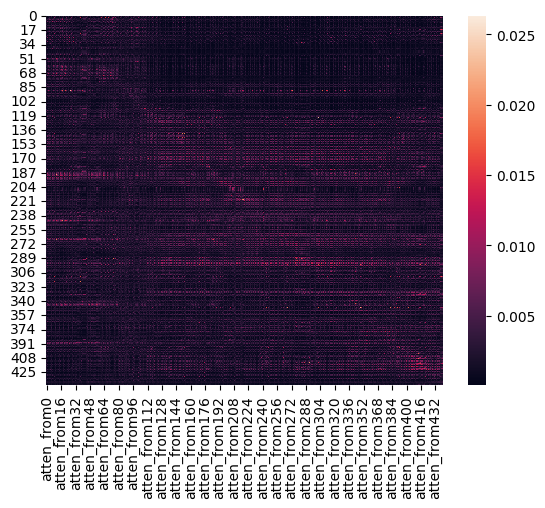

,predicate,whom,subject,why,what,where
0,word.predicate:kill,AbbeyGrange:Lady_Brackenstall,AbbeyGrange:Jack_Croker,AbbeyGrange:Jack_Croker,AbbeyGrange:Lady_Brackenstall,AbbeyGrange:Jack_Croker
1,word.predicate:go,AbbeyGrange:Jack_Croker,AbbeyGrange:Theresa,AbbeyGrange:Lady_Brackenstall,AbbeyGrange:cord_of_bell,AbbeyGrange:Lady_Brackenstall
2,word.predicate:hit,AbbeyGrange:Sir_Eustace_Brackenstall,AbbeyGrange:Lady_Brackenstall,AbbeyGrange:Theresa,AbbeyGrange:Jack_Croker,AbbeyGrange:Theresa
3,word.predicate:exist,AbbeyGrange:Theresa,AbbeyGrange:Sir_Eustace_Brackenstall,AbbeyGrange:cord_of_bell,AbbeyGrange:police,AllTitle:Holmes
4,word.predicate:say,AbbeyGrange:Criminal,AbbeyGrange:Stanley_Hopkins,AbbeyGrange:police,AllTitle:Holmes,AbbeyGrange:cord_of_bell
5,AbbeyGrange:Sir_Eustace_Brackenstall,AllTitle:Holmes,AbbeyGrange:Thought_of_Holmes,AbbeyGrange:Thought_of_Holmes,ResidentPatient:Young_man,SilverBlaze:Silver_Blaze
6,AbbeyGrange:Theresa,AbbeyGrange:police,AbbeyGrange:Criminal,SpeckledBand:Roylott_s_bedroom,AbbeyGrange:Theresa,AllTitle:Watson
7,word.predicate:meet,ResidentPatient:Young_man,DancingMen:Abe_Slaney,word.predicate:unconscious,SilverBlaze:John_Straker,ACaseOfIdentity:Hosmer
8,word.predicate:goOut,SilverBlaze:Silver_Blaze,AllTitle:Holmes,AbbeyGrange:dining_room,AbbeyGrange:Silver_Products,DancingMen:Elsie
9,word.predicate:want,SilverBlaze:Silas_Brown,DevilsFoot:Porter,ACaseOfIdentity:Sutherland,SilverBlaze:knife,DancingMen:Cubitt


In [13]:
victim = 'AbbeyGrange:Sir_Eustace_Brackenstall'
df_ranking_AbbeyGrange, df_attension_AbbeyGrange = make_ranking(
    f'AbbeyGrange:{372-80+1}', 'AbbeyGrange:372', KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

display(df_ranking_AbbeyGrange.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_AbbeyGrange)


In [14]:
for i in range(len_-20, len_):
    display(i, df_attension_AbbeyGrange.iloc[i,:3].tolist())
    display(df_attension_AbbeyGrange.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

421

['AbbeyGrange:370', 'kgc:to', 'AbbeyGrange:Lady_Brackenstall']

,head,relation,tail,atten_from421
296,AbbeyGrange:346,kgc:hasPredicate,word.predicate:stand,0.014993
407,AbbeyGrange:368,kgc:hasPredicate,word.predicate:consider,0.013393
121,AbbeyGrange:316,kgc:hasPredicate,word.predicate:swear,0.012427
289,AbbeyGrange:345,kgc:hasPredicate,word.predicate:hear,0.012405
365,AbbeyGrange:360,kgc:hasPredicate,word.predicate:shout,0.011047
272,AbbeyGrange:342,kgc:hasPredicate,word.predicate:scratch,0.010972
331,AbbeyGrange:353,kgc:hasPredicate,word.predicate:notRegret,0.010803
430,AbbeyGrange:372,kgc:hasPredicate,word.predicate:tie,0.010283
395,AbbeyGrange:366,kgc:hasPredicate,word.predicate:pour,0.010075
419,AbbeyGrange:370,kgc:hasPredicate,word.predicate:say,0.008993


----------


422

['AbbeyGrange:370', 'kgc:infoSource', 'AbbeyGrange:Jack_Croker']

,head,relation,tail,atten_from422
422,AbbeyGrange:370,kgc:infoSource,AbbeyGrange:Jack_Croker,0.013324
409,AbbeyGrange:368,kgc:infoSource,AbbeyGrange:Jack_Croker,0.011854
416,AbbeyGrange:369,kgc:infoSource,AbbeyGrange:Jack_Croker,0.011505
372,AbbeyGrange:361,kgc:infoSource,AbbeyGrange:Jack_Croker,0.011307
420,AbbeyGrange:370,kgc:what,AbbeyGrange:Fiction,0.010176
180,AbbeyGrange:325,kgc:infoSource,AbbeyGrange:Jack_Croker,0.009553
366,AbbeyGrange:360,kgc:infoSource,AbbeyGrange:Jack_Croker,0.009536
418,AbbeyGrange:370,kgc:subject,AbbeyGrange:Theresa,0.009455
291,AbbeyGrange:345,kgc:infoSource,AbbeyGrange:Jack_Croker,0.009266
330,AbbeyGrange:353,kgc:subject,AbbeyGrange:Jack_Croker,0.008709


----------


423

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from423
371,AbbeyGrange:361,kgc:what,AbbeyGrange:Screams_of_Lady_Brackenstall,0.007134
414,AbbeyGrange:369,kgc:what,AbbeyGrange:Death_of_Sir_Eustace_Brackenstall,0.006798
239,AbbeyGrange:336,kgc:what,AbbeyGrange:Theresa,0.005939
355,AbbeyGrange:358,kgc:what,AbbeyGrange:Sir_Eustace_Brackenstall,0.004924
45,bos_e,bos_r,bos_e,0.004680
327,AbbeyGrange:352,kgc:what,AbbeyGrange:Sir_Eustace_Brackenstall,0.004655
123,bos_e,bos_r,bos_e,0.004620
19,bos_e,bos_r,bos_e,0.004500
38,bos_e,bos_r,bos_e,0.004467
24,bos_e,bos_r,bos_e,0.004454


----------


424

['AbbeyGrange:371', 'kgc:subject', 'AbbeyGrange:Jack_Croker']

,head,relation,tail,atten_from424
422,AbbeyGrange:370,kgc:infoSource,AbbeyGrange:Jack_Croker,0.014073
416,AbbeyGrange:369,kgc:infoSource,AbbeyGrange:Jack_Croker,0.011865
409,AbbeyGrange:368,kgc:infoSource,AbbeyGrange:Jack_Croker,0.011404
418,AbbeyGrange:370,kgc:subject,AbbeyGrange:Theresa,0.010945
372,AbbeyGrange:361,kgc:infoSource,AbbeyGrange:Jack_Croker,0.010180
366,AbbeyGrange:360,kgc:infoSource,AbbeyGrange:Jack_Croker,0.009696
171,AbbeyGrange:323,kgc:infoSource,AbbeyGrange:Jack_Croker,0.009041
412,AbbeyGrange:369,kgc:subject,AbbeyGrange:Jack_Croker,0.009016
167,AbbeyGrange:323,kgc:subject,AbbeyGrange:Jack_Croker,0.008854
164,AbbeyGrange:322,kgc:infoSource,AbbeyGrange:Jack_Croker,0.008752


----------


425

['AbbeyGrange:371', 'kgc:hasPredicate', 'word.predicate:cut']

,head,relation,tail,atten_from425
261,AbbeyGrange:340,kgc:what,AbbeyGrange:341,0.007011
113,AbbeyGrange:314,kgc:hasProperty,word.predicate:Ordinary_criminal,0.006645
169,AbbeyGrange:323,kgc:what,AbbeyGrange:love,0.006613
402,AbbeyGrange:367,kgc:what,AbbeyGrange:a_cup_of_wine,0.006309
408,AbbeyGrange:368,kgc:what,AbbeyGrange:Fiction,0.006272
371,AbbeyGrange:361,kgc:what,AbbeyGrange:Screams_of_Lady_Brackenstall,0.006194
422,AbbeyGrange:370,kgc:infoSource,AbbeyGrange:Jack_Croker,0.006104
414,AbbeyGrange:369,kgc:what,AbbeyGrange:Death_of_Sir_Eustace_Brackenstall,0.006099
199,AbbeyGrange:329,kgc:what,AbbeyGrange:328,0.005892
355,AbbeyGrange:358,kgc:what,AbbeyGrange:Sir_Eustace_Brackenstall,0.005682


----------


426

['AbbeyGrange:371', 'kgc:what', 'AbbeyGrange:cord_of_bell']

,head,relation,tail,atten_from426
345,AbbeyGrange:356,kgc:infoSource,AbbeyGrange:Thought_of_Jack_Croker,0.008519
422,AbbeyGrange:370,kgc:infoSource,AbbeyGrange:Jack_Croker,0.008344
391,AbbeyGrange:365,kgc:infoSource,AbbeyGrange:Jack_Croker,0.007783
387,AbbeyGrange:364,kgc:infoSource,AbbeyGrange:Jack_Croker,0.007218
381,AbbeyGrange:363,kgc:infoSource,AbbeyGrange:Jack_Croker,0.007169
168,AbbeyGrange:323,kgc:hasPredicate,word.predicate:have,0.007095
333,AbbeyGrange:353,kgc:infoSource,AbbeyGrange:Jack_Croker,0.007071
403,AbbeyGrange:367,kgc:infoSource,AbbeyGrange:Jack_Croker,0.007009
341,AbbeyGrange:355,kgc:infoSource,AbbeyGrange:Jack_Croker,0.006965
372,AbbeyGrange:361,kgc:infoSource,AbbeyGrange:Jack_Croker,0.006937


----------


427

['AbbeyGrange:371', 'kgc:infoSource', 'AbbeyGrange:Jack_Croker']

,head,relation,tail,atten_from427
422,AbbeyGrange:370,kgc:infoSource,AbbeyGrange:Jack_Croker,0.014912
372,AbbeyGrange:361,kgc:infoSource,AbbeyGrange:Jack_Croker,0.013262
366,AbbeyGrange:360,kgc:infoSource,AbbeyGrange:Jack_Croker,0.011884
409,AbbeyGrange:368,kgc:infoSource,AbbeyGrange:Jack_Croker,0.011651
291,AbbeyGrange:345,kgc:infoSource,AbbeyGrange:Jack_Croker,0.010466
171,AbbeyGrange:323,kgc:infoSource,AbbeyGrange:Jack_Croker,0.010203
416,AbbeyGrange:369,kgc:infoSource,AbbeyGrange:Jack_Croker,0.010176
180,AbbeyGrange:325,kgc:infoSource,AbbeyGrange:Jack_Croker,0.009284
177,AbbeyGrange:325,kgc:subject,AbbeyGrange:Jack_Croker,0.008851
418,AbbeyGrange:370,kgc:subject,AbbeyGrange:Theresa,0.008743


----------


428

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from428
371,AbbeyGrange:361,kgc:what,AbbeyGrange:Screams_of_Lady_Brackenstall,0.006829
414,AbbeyGrange:369,kgc:what,AbbeyGrange:Death_of_Sir_Eustace_Brackenstall,0.006134
239,AbbeyGrange:336,kgc:what,AbbeyGrange:Theresa,0.005987
355,AbbeyGrange:358,kgc:what,AbbeyGrange:Sir_Eustace_Brackenstall,0.005111
327,AbbeyGrange:352,kgc:what,AbbeyGrange:Sir_Eustace_Brackenstall,0.004679
45,bos_e,bos_r,bos_e,0.004657
123,bos_e,bos_r,bos_e,0.004561
252,AbbeyGrange:338,kgc:what,AbbeyGrange:Sir_Eustace_Brackenstall,0.004559
19,bos_e,bos_r,bos_e,0.004480
24,bos_e,bos_r,bos_e,0.004443


----------


429

['AbbeyGrange:372', 'kgc:subject', 'AbbeyGrange:Jack_Croker']

,head,relation,tail,atten_from429
422,AbbeyGrange:370,kgc:infoSource,AbbeyGrange:Jack_Croker,0.011781
418,AbbeyGrange:370,kgc:subject,AbbeyGrange:Theresa,0.010306
409,AbbeyGrange:368,kgc:infoSource,AbbeyGrange:Jack_Croker,0.009873
372,AbbeyGrange:361,kgc:infoSource,AbbeyGrange:Jack_Croker,0.009784
416,AbbeyGrange:369,kgc:infoSource,AbbeyGrange:Jack_Croker,0.009439
295,AbbeyGrange:346,kgc:subject,AbbeyGrange:Lady_Brackenstall,0.009433
369,AbbeyGrange:361,kgc:subject,AbbeyGrange:Theresa,0.008875
411,AbbeyGrange:369,kgc:subject,AbbeyGrange:Theresa,0.008682
23,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.008430
376,AbbeyGrange:362,kgc:infoSource,AbbeyGrange:Jack_Croker,0.008066


----------


430

['AbbeyGrange:372', 'kgc:hasPredicate', 'word.predicate:tie']

,head,relation,tail,atten_from430
255,AbbeyGrange:339,kgc:subject,AbbeyGrange:Jack_Croker,0.006075
257,AbbeyGrange:339,kgc:what,AbbeyGrange:Lady_Brackenstall,0.005994
197,AbbeyGrange:329,kgc:subject,AbbeyGrange:Jack_Croker,0.005983
372,AbbeyGrange:361,kgc:infoSource,AbbeyGrange:Jack_Croker,0.005843
250,AbbeyGrange:338,kgc:subject,AbbeyGrange:Jack_Croker,0.005744
259,AbbeyGrange:340,kgc:subject,AbbeyGrange:Jack_Croker,0.005668
347,AbbeyGrange:357,kgc:subject,AbbeyGrange:Jack_Croker,0.005600
422,AbbeyGrange:370,kgc:infoSource,AbbeyGrange:Jack_Croker,0.005554
254,AbbeyGrange:339,kgc:subject,AbbeyGrange:Theresa,0.005501
353,AbbeyGrange:358,kgc:subject,AbbeyGrange:Jack_Croker,0.005288


----------


431

['AbbeyGrange:372', 'kgc:what', 'AbbeyGrange:Lady_Brackenstall']

,head,relation,tail,atten_from431
311,AbbeyGrange:349,kgc:hasPredicate,word.predicate:have,0.012020
140,AbbeyGrange:319,kgc:hasPredicate,word.predicate:notWant,0.011094
2,AbbeyGrange:293,kgc:hasPredicate,word.predicate:notWant,0.008463
121,AbbeyGrange:316,kgc:hasPredicate,word.predicate:swear,0.007752
145,AbbeyGrange:319a,kgc:hasPredicate,word.predicate:involve,0.007632
263,AbbeyGrange:340,kgc:from,AbbeyGrange:Theresa,0.007597
296,AbbeyGrange:346,kgc:hasPredicate,word.predicate:stand,0.007561
289,AbbeyGrange:345,kgc:hasPredicate,word.predicate:hear,0.007442
26,AbbeyGrange:298,kgc:hasPredicate,word.predicate:fear,0.007284
272,AbbeyGrange:342,kgc:hasPredicate,word.predicate:scratch,0.007252


----------


432

['AbbeyGrange:372', 'kgc:infoSource', 'AbbeyGrange:Jack_Croker']

,head,relation,tail,atten_from432
422,AbbeyGrange:370,kgc:infoSource,AbbeyGrange:Jack_Croker,0.011655
372,AbbeyGrange:361,kgc:infoSource,AbbeyGrange:Jack_Croker,0.010204
418,AbbeyGrange:370,kgc:subject,AbbeyGrange:Theresa,0.009513
409,AbbeyGrange:368,kgc:infoSource,AbbeyGrange:Jack_Croker,0.009481
295,AbbeyGrange:346,kgc:subject,AbbeyGrange:Lady_Brackenstall,0.009466
291,AbbeyGrange:345,kgc:infoSource,AbbeyGrange:Jack_Croker,0.009323
366,AbbeyGrange:360,kgc:infoSource,AbbeyGrange:Jack_Croker,0.008734
288,AbbeyGrange:345,kgc:subject,AbbeyGrange:Jack_Croker,0.008471
294,AbbeyGrange:346,kgc:subject,AbbeyGrange:Jack_Croker,0.008451
416,AbbeyGrange:369,kgc:infoSource,AbbeyGrange:Jack_Croker,0.008200


----------


433

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from433
371,AbbeyGrange:361,kgc:what,AbbeyGrange:Screams_of_Lady_Brackenstall,0.006578
239,AbbeyGrange:336,kgc:what,AbbeyGrange:Theresa,0.006065
414,AbbeyGrange:369,kgc:what,AbbeyGrange:Death_of_Sir_Eustace_Brackenstall,0.005843
355,AbbeyGrange:358,kgc:what,AbbeyGrange:Sir_Eustace_Brackenstall,0.005112
45,bos_e,bos_r,bos_e,0.004646
252,AbbeyGrange:338,kgc:what,AbbeyGrange:Sir_Eustace_Brackenstall,0.004629
327,AbbeyGrange:352,kgc:what,AbbeyGrange:Sir_Eustace_Brackenstall,0.004596
123,bos_e,bos_r,bos_e,0.004526
19,bos_e,bos_r,bos_e,0.004487
24,bos_e,bos_r,bos_e,0.004431


----------


434

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from434
422,AbbeyGrange:370,kgc:infoSource,AbbeyGrange:Jack_Croker,0.011786
409,AbbeyGrange:368,kgc:infoSource,AbbeyGrange:Jack_Croker,0.010759
418,AbbeyGrange:370,kgc:subject,AbbeyGrange:Theresa,0.010618
406,AbbeyGrange:368,kgc:subject,AbbeyGrange:Jack_Croker,0.009407
416,AbbeyGrange:369,kgc:infoSource,AbbeyGrange:Jack_Croker,0.009099
372,AbbeyGrange:361,kgc:infoSource,AbbeyGrange:Jack_Croker,0.008637
330,AbbeyGrange:353,kgc:subject,AbbeyGrange:Jack_Croker,0.008180
412,AbbeyGrange:369,kgc:subject,AbbeyGrange:Jack_Croker,0.007986
23,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.007870
411,AbbeyGrange:369,kgc:subject,AbbeyGrange:Theresa,0.007734


----------


435

['mask_e', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from435
408,AbbeyGrange:368,kgc:what,AbbeyGrange:Fiction,0.008361
113,AbbeyGrange:314,kgc:hasProperty,word.predicate:Ordinary_criminal,0.007390
409,AbbeyGrange:368,kgc:infoSource,AbbeyGrange:Jack_Croker,0.007071
265,AbbeyGrange:341,kgc:subject,AbbeyGrange:Lady_Brackenstall,0.007067
422,AbbeyGrange:370,kgc:infoSource,AbbeyGrange:Jack_Croker,0.007003
414,AbbeyGrange:369,kgc:what,AbbeyGrange:Death_of_Sir_Eustace_Brackenstall,0.006935
372,AbbeyGrange:361,kgc:infoSource,AbbeyGrange:Jack_Croker,0.006496
420,AbbeyGrange:370,kgc:what,AbbeyGrange:Fiction,0.006435
310,AbbeyGrange:349,kgc:subject,AbbeyGrange:Jack_Croker,0.006429
332,AbbeyGrange:353,kgc:what,AbbeyGrange:352,0.006407


----------


436

['mask_e', 'kgc:whom', 'AbbeyGrange:Sir_Eustace_Brackenstall']

,head,relation,tail,atten_from436
418,AbbeyGrange:370,kgc:subject,AbbeyGrange:Theresa,0.010048
422,AbbeyGrange:370,kgc:infoSource,AbbeyGrange:Jack_Croker,0.008411
411,AbbeyGrange:369,kgc:subject,AbbeyGrange:Theresa,0.008291
289,AbbeyGrange:345,kgc:hasPredicate,word.predicate:hear,0.008026
295,AbbeyGrange:346,kgc:subject,AbbeyGrange:Lady_Brackenstall,0.008025
263,AbbeyGrange:340,kgc:from,AbbeyGrange:Theresa,0.007971
416,AbbeyGrange:369,kgc:infoSource,AbbeyGrange:Jack_Croker,0.007670
409,AbbeyGrange:368,kgc:infoSource,AbbeyGrange:Jack_Croker,0.007295
294,AbbeyGrange:346,kgc:subject,AbbeyGrange:Jack_Croker,0.007121
369,AbbeyGrange:361,kgc:subject,AbbeyGrange:Theresa,0.007046


----------


437

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from437
422,AbbeyGrange:370,kgc:infoSource,AbbeyGrange:Jack_Croker,0.009913
23,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.009573
372,AbbeyGrange:361,kgc:infoSource,AbbeyGrange:Jack_Croker,0.009208
295,AbbeyGrange:346,kgc:subject,AbbeyGrange:Lady_Brackenstall,0.009114
416,AbbeyGrange:369,kgc:infoSource,AbbeyGrange:Jack_Croker,0.008900
418,AbbeyGrange:370,kgc:subject,AbbeyGrange:Theresa,0.008792
376,AbbeyGrange:362,kgc:infoSource,AbbeyGrange:Jack_Croker,0.008152
420,AbbeyGrange:370,kgc:what,AbbeyGrange:Fiction,0.008107
263,AbbeyGrange:340,kgc:from,AbbeyGrange:Theresa,0.007842
409,AbbeyGrange:368,kgc:infoSource,AbbeyGrange:Jack_Croker,0.007715


----------


438

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from438
16,AbbeyGrange:296,kgc:hasPredicate,word.predicate:become,0.012364
26,AbbeyGrange:298,kgc:hasPredicate,word.predicate:fear,0.011702
311,AbbeyGrange:349,kgc:hasPredicate,word.predicate:have,0.011667
140,AbbeyGrange:319,kgc:hasPredicate,word.predicate:notWant,0.009974
21,AbbeyGrange:297,kgc:hasPredicate,word.predicate:have,0.009481
2,AbbeyGrange:293,kgc:hasPredicate,word.predicate:notWant,0.009470
121,AbbeyGrange:316,kgc:hasPredicate,word.predicate:swear,0.009443
348,AbbeyGrange:357,kgc:hasPredicate,word.predicate:notLeave,0.008164
204,AbbeyGrange:330,kgc:where,AbbeyGrange:Sydenham,0.007564
317,AbbeyGrange:350,kgc:hasPredicate,word.predicate:fight,0.007554


----------


439

['mask_e', 'kgc:what', 'mask_e']

,head,relation,tail,atten_from439
311,AbbeyGrange:349,kgc:hasPredicate,word.predicate:have,0.017014
16,AbbeyGrange:296,kgc:hasPredicate,word.predicate:become,0.015389
21,AbbeyGrange:297,kgc:hasPredicate,word.predicate:have,0.014941
26,AbbeyGrange:298,kgc:hasPredicate,word.predicate:fear,0.010504
414,AbbeyGrange:369,kgc:what,AbbeyGrange:Death_of_Sir_Eustace_Brackenstall,0.009768
348,AbbeyGrange:357,kgc:hasPredicate,word.predicate:notLeave,0.009497
2,AbbeyGrange:293,kgc:hasPredicate,word.predicate:notWant,0.008700
420,AbbeyGrange:370,kgc:what,AbbeyGrange:Fiction,0.007847
296,AbbeyGrange:346,kgc:hasPredicate,word.predicate:stand,0.007784
121,AbbeyGrange:316,kgc:hasPredicate,word.predicate:swear,0.007774


----------


440

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from440
414,AbbeyGrange:369,kgc:what,AbbeyGrange:Death_of_Sir_Eustace_Brackenstall,0.012925
16,AbbeyGrange:296,kgc:hasPredicate,word.predicate:become,0.010597
121,AbbeyGrange:316,kgc:hasPredicate,word.predicate:swear,0.010300
311,AbbeyGrange:349,kgc:hasPredicate,word.predicate:have,0.010034
348,AbbeyGrange:357,kgc:hasPredicate,word.predicate:notLeave,0.009732
420,AbbeyGrange:370,kgc:what,AbbeyGrange:Fiction,0.009392
408,AbbeyGrange:368,kgc:what,AbbeyGrange:Fiction,0.008965
332,AbbeyGrange:353,kgc:what,AbbeyGrange:352,0.008590
296,AbbeyGrange:346,kgc:hasPredicate,word.predicate:stand,0.007994
26,AbbeyGrange:298,kgc:hasPredicate,word.predicate:fear,0.006507


----------
